In [1]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split 
from keras.utils import to_categorical
from keras.applications.densenet import DenseNet201
from keras.models import Model
from keras.layers import Dense, GlobalAverag,ePooling2D, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt



ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (C:\Users\SRAVAN\anaconda3\Lib\site-packages\keras\preprocessing\image\__init__.py)

In [ ]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
import tensorflow as tf

Total samples: 9418, Training samples: 7534, Validation samples: 1884


Epoch 1/20
235/235 [==============================] - 933s 4s/step - loss: 0.5134 - accuracy: 0.7834 - val_loss: 0.4566 - val_accuracy: 0.7850 - lr: 0.0010
Epoch 2/20
235/235 [==============================] - 890s 4s/step - loss: 0.4375 - accuracy: 0.8043 - val_loss: 0.4514 - val_accuracy: 0.7910 - lr: 0.0010
Epoch 3/20
235/235 [==============================] - 863s 4s/step - loss: 0.4094 - accuracy: 0.8179 - val_loss: 0.4326 - val_accuracy: 0.8040 - lr: 0.0010
Epoch 4/20
235/235 [==============================] - 861s 4s/step - loss: 0.3859 - accuracy: 0.8282 - val_loss: 0.4364 - val_accuracy: 0.8062 - lr: 0.0010
Epoch 5/20
235/235 [==============================] - 868s 4s/step - loss: 0.3769 - accuracy: 0.8295 - val_loss: 0.4384 - val_accuracy: 0.8089 - lr: 0.0010
Epoch 6/20
235/235 [==============================] - 886s 4s/step - loss: 0.3555 - accuracy: 0.8380 - val_loss: 0.4243 - val_accuracy: 0.8121 - lr: 0.0010
Epoch 7/20
235/235 [==============================] - 883s 4s/st

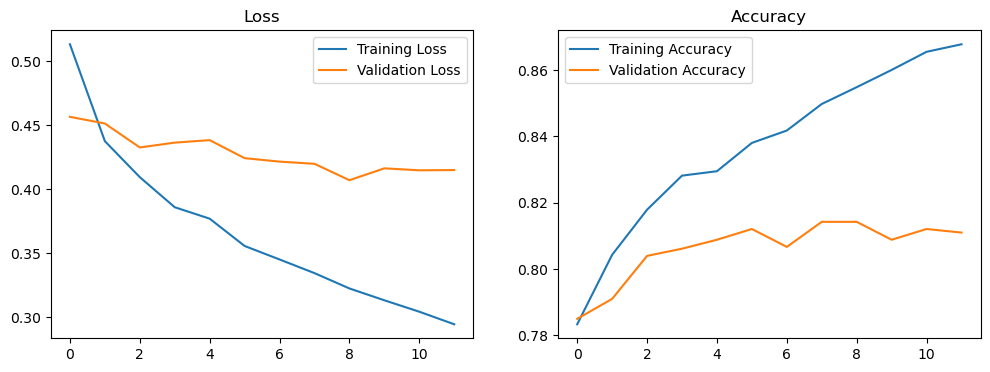

In [4]:
def image_generator(image_paths, labels, batch_size=32):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            batch_images = [prepare_image(path) for path in batch_paths]
            yield np.array(batch_images), np.array(batch_labels)

def prepare_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to be between 0 and 1
    return img_array

X = []
Y = []

# Real images from CASIA2
real_path_casia2 = 'D:\\archive (1)\\CASIA2\\Au\\'
for dirname, _, filenames in os.walk(real_path_casia2):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(full_path)
            Y.append(1)

# Fake images from CASIA2
fake_path_casia2 = 'D:\\archive (1)\\CASIA2\\Tp\\'
for dirname, _, filenames in os.walk(fake_path_casia2):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(full_path)
            Y.append(0)

# Convert labels to categorical
Y = to_categorical(Y, 2)

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f'Total samples: {len(X)}, Training samples: {len(X_train)}, Validation samples: {len(X_val)}')

# Create DenseNet model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Generator for training data
train_data_generator = image_generator(X_train, Y_train, batch_size=32)

# Generator for validation data
val_data_generator = image_generator(X_val, Y_val, batch_size=32)

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,reduce_learningrate]

model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model using the generators
history = model.fit(
    train_data_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=20,
    validation_data=val_data_generator,
    validation_steps=len(X_val) // 32,
    callbacks=callbacks_list
)


# Evaluate the model
score = model.evaluate(val_data_generator, steps=len(X_val) // 32, verbose=0)
print(f'Test loss: {score[0]}, Test accuracy: {score[1]}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()




### Fine Tuening

Epoch 1/20
235/235 [==============================] - 892s 4s/step - loss: 0.3466 - accuracy: 0.8432 - val_loss: 0.4228 - val_accuracy: 0.8126 - lr: 0.0010
Epoch 2/20
235/235 [==============================] - 873s 4s/step - loss: 0.3126 - accuracy: 0.8559 - val_loss: 0.3996 - val_accuracy: 0.8180 - lr: 0.0010
Epoch 3/20
235/235 [==============================] - 864s 4s/step - loss: 0.2890 - accuracy: 0.8660 - val_loss: 0.4338 - val_accuracy: 0.8224 - lr: 0.0010
Epoch 4/20
235/235 [==============================] - 851s 4s/step - loss: 0.2574 - accuracy: 0.8830 - val_loss: 0.4164 - val_accuracy: 0.8218 - lr: 0.0010
Epoch 5/20
235/235 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.8868Restoring model weights from the end of the best epoch: 2.

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
235/235 [==============================] - 872s 4s/step - loss: 0.2336 - accuracy: 0.8868 - val_loss: 0.5237 - val_accuracy: 0.8218 - lr: 0.0010

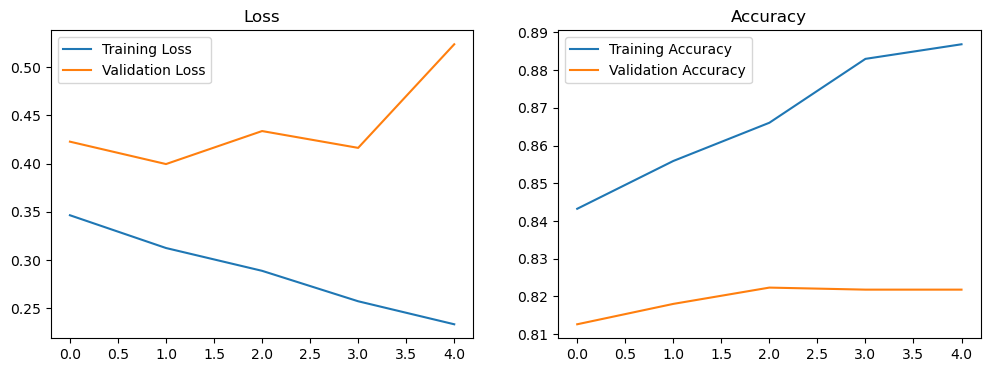

In [6]:
early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,reduce_learningrate]

# Fine-tuning: Unfreeze the last 20 layers
for layer in model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_data_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=20,
    validation_data=val_data_generator,
    validation_steps=len(X_val) // 32,
    callbacks=callbacks_list
)

# Evaluate the model
score = model.evaluate(val_data_generator, steps=len(X_val) // 32, verbose=0)
print(f'Test loss: {score[0]}, Test accuracy: {score[1]}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


### Attention Mechanism

Total samples: 9418, Training samples: 7534, Validation samples: 1884
Epoch 1/20
235/235 [==============================] - 878s 4s/step - loss: 0.5675 - accuracy: 0.7781 - val_loss: 0.5664 - val_accuracy: 0.7689 - lr: 1.0000e-04
Epoch 2/20
235/235 [==============================] - 963s 4s/step - loss: 0.5503 - accuracy: 0.7838 - val_loss: 0.5538 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 3/20
235/235 [==============================] - 1049s 4s/step - loss: 0.5406 - accuracy: 0.7841 - val_loss: 0.5474 - val_accuracy: 0.7721 - lr: 1.0000e-04
Epoch 4/20
235/235 [==============================] - 1105s 5s/step - loss: 0.5347 - accuracy: 0.7834 - val_loss: 0.5450 - val_accuracy: 0.7700 - lr: 1.0000e-04
Epoch 5/20
235/235 [==============================] - 1093s 5s/step - loss: 0.5303 - accuracy: 0.7834 - val_loss: 0.5407 - val_accuracy: 0.7716 - lr: 1.0000e-04
Epoch 6/20
235/235 [==============================] - 873s 4s/step - loss: 0.5272 - accuracy: 0.7835 - val_loss: 0.5408 - val_a

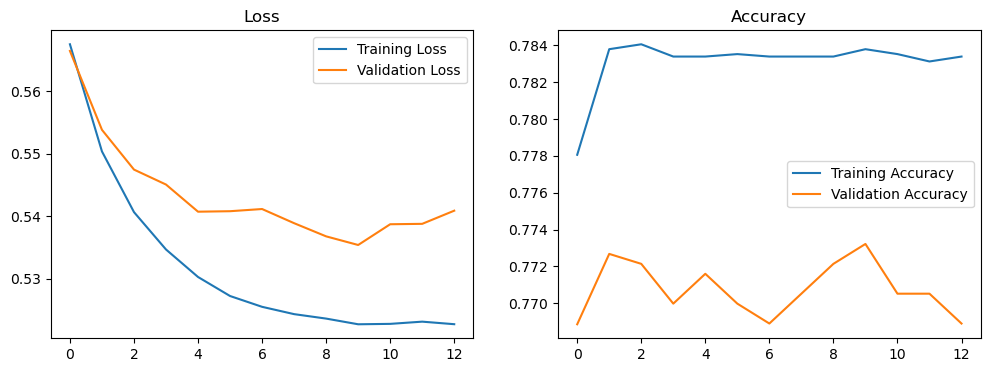

In [7]:
def add_attention(model):
    attention = tf.keras.layers.Attention()  # Attention mechanism
    x = model.output
    context = attention([x, x])
    x = tf.keras.layers.Concatenate()([x, context])
    predictions = Dense(2, activation='softmax')(x)
    model_attention = Model(inputs=model.input, outputs=predictions)
    return model_attention
def image_generator(image_paths, labels, batch_size=32):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            batch_images = [prepare_image(path) for path in batch_paths]
            yield np.array(batch_images), np.array(batch_labels)

def prepare_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to be between 0 and 1
    return img_array

X = []
Y = []

# Real images from CASIA2
real_path_casia2 = 'D:\\archive (1)\\CASIA2\\Au\\'
for dirname, _, filenames in os.walk(real_path_casia2):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(full_path)
            Y.append(1)

# Fake images from CASIA2
fake_path_casia2 = 'D:\\archive (1)\\CASIA2\\Tp\\'
for dirname, _, filenames in os.walk(fake_path_casia2):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(full_path)
            Y.append(0)

# Convert labels to categorical
Y = to_categorical(Y, 2)

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f'Total samples: {len(X)}, Training samples: {len(X_train)}, Validation samples: {len(X_val)}')

# Create DenseNet model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Add Attention mechanism to the model
model_attention = add_attention(model)

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,reduce_learningrate]

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Compile the model_attention
model_attention.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Generator for training data
train_data_generator = image_generator(X_train, Y_train, batch_size=32)

# Generator for validation data
val_data_generator = image_generator(X_val, Y_val, batch_size=32)

# Train the model_attention
epochs = 20

history = model_attention.fit(
    train_data_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=20,
    validation_data=val_data_generator,
    validation_steps=len(X_val) // 32,
    callbacks=callbacks_list
)
# Evaluate the model
score = model.evaluate(val_data_generator, steps=len(X_val) // 32, verbose=0)
print(f'Test loss: {score[0]}, Test accuracy: {score[1]}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

### Cross Model

Total samples: 9418, Training samples: 7534, Validation samples: 1884
Fold 1/5


Epoch 1/10
235/235 [==============================] - 1208s 5s/step - loss: 0.4118 - accuracy: 0.9763 - val_loss: 13.5797 - val_accuracy: 0.2074 - lr: 0.0010
Epoch 2/10
235/235 [==============================] - 1116s 5s/step - loss: 1.2213 - accuracy: 0.7894 - val_loss: 4.1417 - val_accuracy: 0.2230 - lr: 0.0010
Epoch 3/10
235/235 [==============================] - 933s 4s/step - loss: 0.8623 - accuracy: 0.7495 - val_loss: 0.5811 - val_accuracy: 0.7770 - lr: 0.0010
Epoch 4/10
235/235 [==============================] - 848s 4s/step - loss: 0.5765 - accuracy: 0.7842 - val_loss: 0.5618 - val_accuracy: 0.7770 - lr: 0.0010
Epoch 5/10
235/235 [==============================] - 862s 4s/step - loss: 0.7643 - accuracy: 0.7842 - val_loss: 0.5547 - val_accuracy: 0.7770 - lr: 0.0010
Epoch 6/10
235/235 [==============================] - 860s 4s/step - loss: 0.5529 - accuracy: 0.7842 - val_loss: 0.5461 - val_accuracy: 0.7770 - lr: 0.0010
Epoch 7/10
235/235 [==============================] - 951s 4s

Epoch 1/10
235/235 [==============================] - 914s 4s/step - loss: 0.4678 - accuracy: 0.9737 - val_loss: 11.5532 - val_accuracy: 0.2074 - lr: 0.0010
Epoch 2/10
235/235 [==============================] - 858s 4s/step - loss: 1.0843 - accuracy: 0.6901 - val_loss: 0.6584 - val_accuracy: 0.7743 - lr: 0.0010
Epoch 3/10
235/235 [==============================] - 840s 4s/step - loss: 0.6391 - accuracy: 0.7842 - val_loss: 0.6021 - val_accuracy: 0.7770 - lr: 0.0010
Epoch 4/10
235/235 [==============================] - 851s 4s/step - loss: 0.7640 - accuracy: 0.7842 - val_loss: 0.5791 - val_accuracy: 0.7770 - lr: 0.0010
Epoch 5/10
235/235 [==============================] - 860s 4s/step - loss: 0.5199 - accuracy: 0.8351 - val_loss: 7.9065 - val_accuracy: 0.2230 - lr: 0.0010
Epoch 6/10
235/235 [==============================] - 847s 4s/step - loss: 0.8399 - accuracy: 0.7733 - val_loss: 3.8500 - val_accuracy: 0.2230 - lr: 0.0010
Epoch 7/10
235/235 [==============================] - 853s 4s/s

Epoch 1/10
235/235 [==============================] - 877s 4s/step - loss: 0.4377 - accuracy: 0.9782 - val_loss: 13.8085 - val_accuracy: 0.2074 - lr: 0.0010
Epoch 2/10
235/235 [==============================] - 861s 4s/step - loss: 1.3326 - accuracy: 0.7897 - val_loss: 9.8943 - val_accuracy: 0.2230 - lr: 0.0010
Epoch 3/10
235/235 [==============================] - 889s 4s/step - loss: 1.0494 - accuracy: 0.7579 - val_loss: 2.8469 - val_accuracy: 0.2230 - lr: 0.0010
Epoch 4/10
235/235 [==============================] - 851s 4s/step - loss: 0.7128 - accuracy: 0.7622 - val_loss: 0.5785 - val_accuracy: 0.7770 - lr: 0.0010
Epoch 5/10
235/235 [==============================] - 856s 4s/step - loss: 0.5742 - accuracy: 0.7841 - val_loss: 0.5612 - val_accuracy: 0.7770 - lr: 0.0010
Epoch 6/10
235/235 [==============================] - 843s 4s/step - loss: 0.5686 - accuracy: 0.7753 - val_loss: 0.5489 - val_accuracy: 0.7770 - lr: 0.0010
Epoch 7/10
235/235 [==============================] - 854s 4s/s

Epoch 1/10
235/235 [==============================] - 946s 4s/step - loss: 0.4632 - accuracy: 0.9767 - val_loss: 11.2034 - val_accuracy: 0.2074 - lr: 0.0010
Epoch 2/10
235/235 [==============================] - 884s 4s/step - loss: 1.2019 - accuracy: 0.6987 - val_loss: 3.5934 - val_accuracy: 0.2226 - lr: 0.0010
Epoch 3/10
235/235 [==============================] - 850s 4s/step - loss: 0.7751 - accuracy: 0.8091 - val_loss: 5.4186 - val_accuracy: 0.2226 - lr: 0.0010
Epoch 4/10
235/235 [==============================] - 869s 4s/step - loss: 0.8167 - accuracy: 0.7504 - val_loss: 0.5773 - val_accuracy: 0.7774 - lr: 0.0010
Epoch 5/10
235/235 [==============================] - 862s 4s/step - loss: 0.5660 - accuracy: 0.7918 - val_loss: 1.1117 - val_accuracy: 0.2231 - lr: 0.0010
Epoch 6/10
235/235 [==============================] - 859s 4s/step - loss: 0.6245 - accuracy: 0.7720 - val_loss: 0.5471 - val_accuracy: 0.7774 - lr: 0.0010
Epoch 7/10
235/235 [==============================] - 850s 4s/s

Epoch 1/10
235/235 [==============================] - 879s 4s/step - loss: 0.4334 - accuracy: 0.9743 - val_loss: 6.0824 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 2/10
235/235 [==============================] - 874s 4s/step - loss: 0.9228 - accuracy: 0.5942 - val_loss: 0.6304 - val_accuracy: 0.7769 - lr: 0.0010
Epoch 3/10
235/235 [==============================] - 879s 4s/step - loss: 0.5959 - accuracy: 0.8093 - val_loss: 3.5673 - val_accuracy: 0.2231 - lr: 0.0010
Epoch 4/10
235/235 [==============================] - 885s 4s/step - loss: 0.7090 - accuracy: 0.7650 - val_loss: 0.5651 - val_accuracy: 0.7769 - lr: 0.0010
Epoch 5/10
235/235 [==============================] - 853s 4s/step - loss: 0.4634 - accuracy: 0.8695 - val_loss: 6.4702 - val_accuracy: 0.2231 - lr: 0.0010
Epoch 6/10
235/235 [==============================] - 853s 4s/step - loss: 0.7916 - accuracy: 0.7621 - val_loss: 0.5399 - val_accuracy: 0.7769 - lr: 0.0010
Epoch 7/10
235/235 [==============================] - 851s 4s/st

Test loss: 0.5811761021614075, Test accuracy: 0.7705183625221252


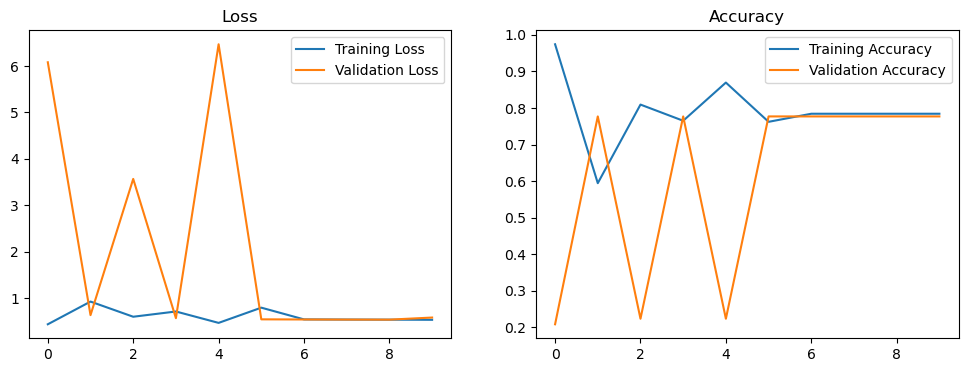

In [9]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
from keras.applications.densenet import DenseNet201
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt

def image_generator(image_paths, labels, batch_size=32):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            batch_images = [prepare_image(path) for path in batch_paths]
            yield np.array(batch_images), np.array(batch_labels)

def prepare_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to be between 0 and 1
    return img_array

X = []
Y = []

# Real images from CASIA2
real_path_casia2 = 'D:\\archive (1)\\CASIA2\\Au\\'
for dirname, _, filenames in os.walk(real_path_casia2):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(full_path)
            Y.append(1)

# Fake images from CASIA2
fake_path_casia2 = 'D:\\archive (1)\\CASIA2\\Tp\\'
for dirname, _, filenames in os.walk(fake_path_casia2):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(full_path)
            Y.append(0)

# Convert labels to categorical
Y = to_categorical(Y, 2)

# Split the data into training and validation sets
X_train_fold, X_val_fold, Y_train_fold, Y_val_fold = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f'Total samples: {len(X)}, Training samples: {len(X_train)}, Validation samples: {len(X_val)}')

# Number of folds for cross-validation
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Iterate through each fold
for fold, (train_indices, val_indices) in enumerate(skf.split(X, np.argmax(Y, axis=1))):
    print(f'Fold {fold + 1}/{num_folds}')

    # Split data into training and validation sets for this fold
    X_train_fold = [X[i] for i in train_indices]
    Y_train_fold = Y[train_indices]
    X_val_fold = [X[i] for i in val_indices]
    Y_val_fold = Y[val_indices]

    # Create generators for training and validation data for this fold
    train_data_generator_fold = image_generator(X_train_fold, Y_train_fold, batch_size=32)
    val_data_generator_fold = image_generator(X_val_fold, Y_val_fold, batch_size=32)

    # Create DenseNet model
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

    reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

    callbacks_list = [early_stopping,reduce_learningrate]

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    

    # Train the model for this fold
    history_fold = model.fit(
        train_data_generator_fold,
        steps_per_epoch=len(X_train_fold) // 32,
        epochs=10,
        validation_data=val_data_generator_fold,
        validation_steps=len(X_val_fold) // 32,
        callbacks=callbacks_list
    )

# Compile the model for the final training
model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

# Evaluate the model
score = model.evaluate(val_data_generator, steps=len(X_val) // 32, verbose=0)
print(f'Test loss: {score[0]}, Test accuracy: {score[1]}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fold.history['loss'], label='Training Loss')
plt.plot(history_fold.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history_fold.history['accuracy'], label='Training Accuracy')
plt.plot(history_fold.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()



In [19]:
# Example test image path
test_image_path = r"D:\archive (1)\CASIA2\Tp\Tp_D_CNN_M_N_txt10109_txt10110_10816.jpg"

# Prepare the test image
test_image = prepare_image(test_image_path)

# Expand dimensions to match the input shape expected by the model
test_image = np.expand_dims(test_image, axis=0)

# Make predictions
predictions = model.predict(test_image)

# Convert predictions to class labels
predicted_class = np.argmax(predictions)

# Print the predicted class
if predicted_class == 1:
    print("Predicted: Real")
else:
    print("Predicted: Fake")


1/1 [==============================] - 1s 1s/step
Predicted: Real


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def image_generator(image_paths, labels, batch_size=32):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            batch_images = [prepare_image(path) for path in batch_paths]
            yield np.array(batch_images), np.array(batch_labels)

def prepare_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to be between 0 and 1
    return img_array

X = []
Y = []

# Real images from CASIA2
real_path_casia2 = "C:\\Users\\vamsi\\Downloads\\archive (1)\\CASIA1\\Au\\"
for dirname, _, filenames in os.walk(real_path_casia2):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(full_path)
            Y.append(1)

# Fake images from CASIA2
fake_path_casia2 =  "C:\\Users\\vamsi\\Downloads\\archive (1)\\CASIA1\\Sp\\"
for dirname, _, filenames in os.walk(fake_path_casia2):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(full_path)
            Y.append(0)

# Convert labels to categorical
Y = to_categorical(Y, 2)

# Split the data into training, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print(f'Total samples: {len(X)}, Training samples: {len(X_train)}, Validation samples: {len(X_val)}, Test samples: {len(X_test)}')

# Create DenseNet model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Generator for training data
train_data_generator = image_generator(X_train, Y_train, batch_size=32)

# Generator for validation data
val_data_generator = image_generator(X_val, Y_val, batch_size=32)

# Generator for test data
test_data_generator = image_generator(X_test, Y_test, batch_size=32)

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=3,
                               verbose=1,
                               restore_best_weights=True
                               )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.2,
                                       patience=3,
                                       verbose=1,
                                       min_delta=0.0001)

callbacks_list = [early_stopping, reduce_learningrate]

model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the generators
history = model.fit(
    train_data_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=20,
    validation_data=val_data_generator,
    validation_steps=len(X_val) // 32,
    callbacks=callbacks_list
)

# Evaluate the model on the test set
test_score = model.evaluate(test_data_generator, steps=len(X_test) // 32, verbose=0)
print(f'Test loss: {test_score[0]}, Test accuracy: {test_score[1]}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

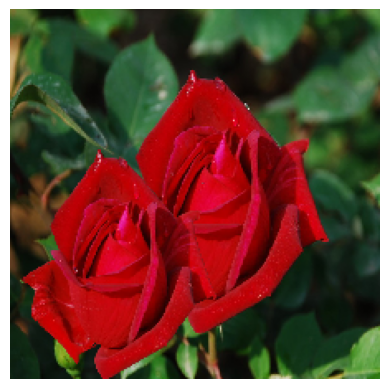

1/1 [==============================] - 0s 266ms/step
Predicted class: 0
Predicted label: Fake


In [18]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = r"C:\Users\vamsi\Downloads\archive (1)\CASIA2\Tp\Tp_S_NRN_S_N_pla20083_pla20083_01983.tif" # Replace with the path to your test image
img = image.load_img(img_path, target_size=(224, 224))  # Assuming your model expects input size (224, 224, 3)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize pixel values to be between 0 and 1

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Get model prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Print the predicted class
print("Predicted class:", predicted_class)

# Map the class index to the actual class name
class_labels = {0: 'Fake', 1: 'Real'}  # Replace with your actual class names

# Print the predicted class (Real or Fake)
predicted_label = class_labels.get(predicted_class, 'Unknown')
print("Predicted label:", predicted_label)

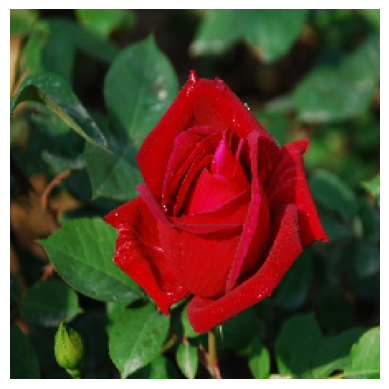

1/1 [==============================] - 0s 260ms/step
Predicted class: 1
Predicted label: Real


In [19]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = r"C:\Users\vamsi\Downloads\archive (1)\CASIA2\Au\Au_pla_20083.jpg"  # Replace with the path to your test image
img = image.load_img(img_path, target_size=(224, 224))  # Assuming your model expects input size (224, 224, 3)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize pixel values to be between 0 and 1

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Get model prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Print the predicted class
print("Predicted class:", predicted_class)

# Map the class index to the actual class name
class_labels = {0: 'Fake', 1: 'Real'}  # Replace with your actual class names

# Print the predicted class (Real or Fake)
predicted_label = class_labels.get(predicted_class, 'Unknown')
print("Predicted label:", predicted_label)